In [ ]:
import pandas as pd
import random
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel  
import adapters
from adapters import AutoAdapterModel
import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.legacy.embeddings import generate_embeddings
from text_embeddings_src.legacy.model_stuff import fix_all_seeds

from text_embeddings_src.plotting import (
    plot_label_tags,
    plot_tsne_colors,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [ ]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [ ]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [ ]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers,openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-11-29 13:21:29CET

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.28.0

transformers: 4.45.2
openTSNE    : 1.0.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-553.el8_10.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

distro             : 1.9.0
jupyter_black      : 0.4.0
memory_profiler    : 0.61.0
numpy              : 1.26.4
transformers       : 4.45.2
pandas             : 2.2.3
sklearn            : 1.5.2
adapters           : 1.0.1
text_embeddings_src: 0.0.0
matplotlib         : 3.9.2
torch              : 2.5.0
black              : 24.10.0
openTSNE           : 1.0.2
scipy              : 1.11.4

Watermark: 2.5.0

Ubuntu 24.04 LTS


# Import

In [ ]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    engine="pyarrow",
)

CPU times: user 269 ms, sys: 84.3 ms, total: 354 ms
Wall time: 266 ms


In [ ]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [ ]:
iclr2024

index  year          id  \
0          0  2017   S1VaB4cex   
1          1  2017   H1W1UN9gg   
2          2  2017   r1GKzP5xx   
3          3  2017   S1J0E-71l   
4          4  2017   SJGCiw5gl   
...      ...   ...         ...   
24342   7299  2024  1bbPQShCT2   
24343   7300  2024  Ny150AblPu   
24344   7301  2024  ZGBOfAQrMl   
24345   7302  2024  J2kRjUAOLh   
24346   7303  2024  U0P622bfUN   

                                                   title  \
0      FractalNet: Ultra-Deep Neural Networks without...   
1                           Deep Information Propagation   
2                    Recurrent Normalization Propagation   
3        Surprisal-Driven Feedback in Recurrent Networks   
4      Pruning Convolutional Neural Networks for Reso...   
...                                                  ...   
24342            I-PHYRE: Interactive Physical Reasoning   
24343  EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...   
24344  Video Super-Resolution Transformer with Masked...   
24345  Contrastive Predict-and-Search for Mixed Integ...   
24346  Federated Generative Learning with Foundation ...   

                                                abstract  \
0      We introduce a design strategy for neural netw...   
1      We study the behavior of untrained neural netw...   
2      We propose a LSTM parametrization  that preser...   
3      Recurrent neural nets are widely used for pred...   
4      We propose a new formulation for pruning convo...   
...                                                  ...   
24342  Current evaluation protocols predominantly ass...   
24343  In the battle against widespread online misinf...   
24344  Recently, Vision Transformer has achieved grea...   
24345  Mixed integer linear programs  (MILP) are flex...   
24346  Existing federated learning solutions focus on...   

                                                 authors  \
0      Gustav Larsson, Michael Maire, Gregory Shakhna...   
1      Samuel S. Schoenholz, Justin Gilmer, Surya Gan...   
2          César Laurent, Nicolas Ballas, Pascal Vincent   
3                        K, a, m, i, l,  , R, o, c, k, i   
4      Pavlo Molchanov, Stephen Tyree, Tero Karras, T...   
...                                                  ...   
24342                                                      
24343                                                      
24344                                                      
24345                                                      
24346                                                      

                       decision        scores  \
0               Accept (Poster)  [5, 7, 6, 6]   
1               Accept (Poster)     [8, 9, 8]   
2      Invite to Workshop Track     [4, 6, 6]   
3                        Reject     [3, 4, 3]   
4               Accept (Poster)     [6, 7, 9]   
...                         ...           ...   
24342                                      []   
24343                                      []   
24344                                      []   
24345                                      []   
24346                                      []   

                                                keywords gender-first  \
0                                                     []         male   
1                                [theory, deep learning]         male   
2                          [deep learning, optimization]         None   
3      [unsupervised learning, applications, deep lea...         None   
4                     [deep learning, transfer learning]         None   
...                                                  ...          ...   
24342            [intuitive physics, physical reasoning]         None   
24343            [mis-contextualization, media forensic]         None   
24344  [video super-resolution, adaptive, memory and ...         None   
24345     [mixed integer programs; contrastive learning]         None   
24346                 [federated learning, 

In [ ]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

# High-dimensional representation

## BERT-based models

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    "allenai/specter2_base",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    if model_name == "SPECTER2":
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoAdapterModel.from_pretrained(model_paths[i])
        print(model_paths[i])
        # add adapter proximity
        model.load_adapter(
            "allenai/specter2",
            source="hf",
            load_as="specter2",
            set_active=True,
        )

    else:
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

    model = model.to(device)

    # get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(iclr2024.abstract.to_list(), tokenizer, model, device, batch_size=256)

    # save embeddings
    saving_path = Path("embeddings_" + model_name.lower()) / Path("updated_dataset")
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path/saving_path/"embedding_abstracts_only_cls", embedding_cls)
    np.save(variables_path/saving_path/"embedding_abstracts_only_sep", embedding_sep)
    np.save(variables_path/saving_path/"embedding_abstracts_only_av", embedding_av)
    
    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print('----------------------------')



Model:  BERT
Running on device: cuda
bert-base-uncased


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Running on device: cuda


model.safetensors:   0%|          | 0.00/532M [00:00<?, ?B/s]

Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SciBERT
Running on device: cuda
allenai/scibert_scivocab_uncased


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SPECTER
Running on device: cuda
allenai/specter


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SciNCL
Running on device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

malteos/scincl


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 11min 46s, sys: 18min 51s, total: 30min 38s
Wall time: 21min


### Add ST5

Using library `SentenceTransformers` (v 2.5.1).

When sentence_transformers is used in output_value="token_embeddings" mode, a "end of senctence" ("eos", similar to CLS) token is appended at the end of the sentence before the padding. The output of model.encode is a list though, and it has no padding tokens in every element, so the EOS token is just the last one.

<!-- I dont really know what the output is in mode output_value="sentence_embeddings", but I asume mean pooling of all tokens. -->

In [ ]:
model_names = [
    "ST5",
]


model_paths = [
    "sentence-transformers/sentence-t5-base",
]
print(model_names)

['ST5']


In [ ]:
%%time
i = 0
model_name = model_names[i]

# set up model
print("Model: ", model_name)

random_state = random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

print(model_paths[i])
model = SentenceTransformer(model_paths[i], device="cuda")

# get embeddings
embedding_av = model.encode(
    iclr2024.abstract.to_list(),
    batch_size=256,
    show_progress_bar=True,
    output_value="sentence_embedding",
    device="cuda",
    normalize_embeddings=False,  # the output is still normalized for some reason
)

# save embeddings
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

# np.save(
#     variables_path / saving_path / "embedding_abstracts_only_cls",
#     embedding_cls,
# )
# np.save(variables_path/saving_path/"embedding_abstracts_only_sep", embedding_sep)
np.save(
    variables_path / saving_path / "embedding_abstracts_only_av", embedding_av
)

model = None
gc.collect()
torch.cuda.empty_cache()

Model:  ST5
Running on device: cuda
sentence-transformers/sentence-t5-base


Batches:   0%|          | 0/96 [00:00<?, ?it/s]

CPU times: user 2min 42s, sys: 1min 17s, total: 4min
Wall time: 1min 25s


### Rebuttal: Add BGE BAAI

In [ ]:
model_names = [
    "BGE",
]


model_paths = [
    "BAAI/llm-embedder",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model: ", model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    if model_name == "SPECTER2":
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoAdapterModel.from_pretrained(model_paths[i])
        print(model_paths[i])
        # add adapter proximity
        model.load_adapter(
            "allenai/specter2",
            source="hf",
            load_as="specter2",
            set_active=True,
        )

    else:
        tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
        model = AutoModel.from_pretrained(model_paths[i])
        print(model_paths[i])

    model = model.to(device)

    # get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(iclr2024.abstract.to_list(), tokenizer, model, device, batch_size=256)

    # save embeddings
    saving_path = Path("embeddings_" + model_name.lower()) / Path("updated_dataset")
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path/saving_path/"embedding_abstracts_only_cls", embedding_cls)
    np.save(variables_path/saving_path/"embedding_abstracts_only_sep", embedding_sep)
    np.save(variables_path/saving_path/"embedding_abstracts_only_av", embedding_av)
    
    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print('----------------------------')



Model:  BGE
Running on device: cuda
BAAI/llm-embedder


  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------
CPU times: user 4min 1s, sys: 20.4 s, total: 4min 22s
Wall time: 2min 45s


## Random BERT

In [ ]:
%%time

model_name = "random_bert"
# set up model
print('Model: ', model_name)

random_state = random.seed(42)
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)  
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

model = model.to(device)

# get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings(iclr2024.abstract.to_list(), tokenizer, model, device, batch_size=256)

# save embeddings
saving_path = Path("embeddings_" + model_name.lower()) / Path("updated_dataset")
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(variables_path/saving_path/"embedding_abstracts_only_cls", embedding_cls)
np.save(variables_path/saving_path/"embedding_abstracts_only_sep", embedding_sep)
np.save(variables_path/saving_path/"embedding_abstracts_only_av", embedding_av)

model = None
gc.collect()
torch.cuda.empty_cache()

print('----------------------------')



Model:  random_bert
Running on device: cuda


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1min 27s, sys: 2min 58s, total: 4min 26s
Wall time: 3min 17s


## TF-IDF

In [ ]:
%%time
%%memit

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(iclr2024.abstract.to_list())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 3704.16 MiB, increment: 0.02 MiB
CPU times: user 2.49 s, sys: 184 ms, total: 2.67 s
Wall time: 2.84 s


In [ ]:
print(tfidf_features.shape)

(24347, 44189)


In [ ]:
# save results
sp.sparse.save_npz(variables_path / "updated_dataset" / "tfidf_features", tfidf_features)

### Truncated SVD

In [ ]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=768, random_state=42, algorithm="arpack")
svd_data = svd.fit_transform(tfidf_features)

# save results
np.save(variables_path / "updated_dataset" / "svd_data", svd_data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 3704.11 MiB, increment: 0.00 MiB
CPU times: user 52min 5s, sys: 1h 3min 20s, total: 1h 55min 26s
Wall time: 2min 47s


### RP

In [ ]:
%%time
%%memit
np.random.seed(42)
P = 2 * np.random.randint(0, 2, size=(tfidf_features.shape[1], 768)) - 1
random_projection = tfidf_features @ P
print(random_projection.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(24347, 768)
peak memory: 3220.09 MiB, increment: 140.10 MiB
CPU times: user 1.34 s, sys: 274 ms, total: 1.61 s
Wall time: 1.69 s


In [ ]:
np.save(variables_path / "updated_dataset" / "random_projection", random_projection)

# t-SNE
Compute t-SNE and calculate kNN accuracy in the 2D representation.

Not run for ST5 or Random BERT.

## BERT-based models

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    "allenai/specter2_base",
]

In [ ]:
%%time
%%memit
print("kNN accuracy          [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # import
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    embedding_cls = np.load(
        variables_path / saving_path / "embedding_abstracts_only_cls.npy"
    )
    embedding_sep = np.load(
        variables_path / saving_path / "embedding_abstracts_only_sep.npy"
    )
    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    # t-SNE
    A = affinity.Uniform(
        embedding_cls,
        verbose=False,
        method="exact",
        random_state=42,
        k_neighbors=10,
    )
    tsne_cls = TSNE(
        verbose=False, initialization="spectral", random_state=42
    ).fit(affinities=A)

    A = affinity.Uniform(
        embedding_sep,
        verbose=False,
        method="exact",
        random_state=42,
        k_neighbors=10,
    )
    tsne_sep = TSNE(
        verbose=False, initialization="spectral", random_state=42
    ).fit(affinities=A)

    A = affinity.Uniform(
        embedding_av,
        verbose=False,
        method="exact",
        random_state=42,
        k_neighbors=10,
    )
    tsne_av = TSNE(
        verbose=False, initialization="spectral", random_state=42
    ).fit(affinities=A)

    # save
    np.save(variables_path / saving_path / "tsne_cls.npy", tsne_cls)
    np.save(variables_path / saving_path / "tsne_sep.npy", tsne_sep)
    np.save(variables_path / saving_path / "tsne_av.npy", tsne_av)


KeyboardInterrupt



## TF-IDF

In [ ]:
# save results
#tfidf_features = sp.sparse.load_npz(variables_path / "tfidf_features.npz")

In [ ]:
%%time
%%memit
A = affinity.Uniform(
    tfidf_features,
    verbose=True,
    method="exact",
    random_state=42,
    k_neighbors=10,
)
tsne_tfidf = TSNE(
    verbose=True, initialization="spectral", random_state=42
).fit(affinities=A)

np.save(variables_path / "updated_dataset" / "tsne_tfidf", tsne_tfidf)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


===> Finding 10 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 243.62 seconds
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='spectral', random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating spectral initialization...


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


   --> Time elapsed: 0.62 seconds
===> Running optimization with exaggeration=12.00, lr=2028.92 for 250 iterations...
Iteration   50, KL divergence 7.4073, 50 iterations in 0.9938 sec
Iteration  100, KL divergence 7.3873, 50 iterations in 0.9474 sec
Iteration  150, KL divergence 7.3777, 50 iterations in 1.0604 sec
Iteration  200, KL divergence 7.3804, 50 iterations in 0.9906 sec
Iteration  250, KL divergence 7.3794, 50 iterations in 1.0405 sec
   --> Time elapsed: 5.03 seconds
===> Running optimization with exaggeration=1.00, lr=24347.00 for 500 iterations...
Iteration   50, KL divergence 4.5737, 50 iterations in 1.0237 sec
Iteration  100, KL divergence 4.3021, 50 iterations in 1.7832 sec
Iteration  150, KL divergence 4.1785, 50 iterations in 2.7014 sec
Iteration  200, KL divergence 4.1070, 50 iterations in 4.1291 sec
Iteration  250, KL divergence 4.0566, 50 iterations in 5.2516 sec
Iteration  300, KL divergence 4.0217, 50 iterations in 5.7286 sec
Iteration  350, KL divergence 3.9939, 

### Truncated SVD

In [ ]:
#svd_data = np.load(variables_path / "svd_data.npy")

In [ ]:
%%time
%%memit
A = affinity.Uniform(
    svd_data[:, :100],
    verbose=True,
    method="exact",
    random_state=42,
    k_neighbors=10,
)
tsne_svd = TSNE(verbose=True, initialization="spectral", random_state=42).fit(
    affinities=A
)

np.save(variables_path / "updated_dataset" / "tsne_svd", tsne_svd)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


===> Finding 10 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.49 seconds
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='spectral', random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating spectral initialization...


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


   --> Time elapsed: 0.33 seconds
===> Running optimization with exaggeration=12.00, lr=2028.92 for 250 iterations...
Iteration   50, KL divergence 7.0280, 50 iterations in 1.0913 sec
Iteration  100, KL divergence 7.0042, 50 iterations in 1.0770 sec
Iteration  150, KL divergence 7.0058, 50 iterations in 1.0373 sec
Iteration  200, KL divergence 6.9946, 50 iterations in 0.9768 sec
Iteration  250, KL divergence 7.0005, 50 iterations in 1.0206 sec
   --> Time elapsed: 5.20 seconds
===> Running optimization with exaggeration=1.00, lr=24347.00 for 500 iterations...


Iteration   50, KL divergence 4.3415, 50 iterations in 1.0864 sec
Iteration  100, KL divergence 4.1299, 50 iterations in 1.6510 sec
Iteration  150, KL divergence 4.0398, 50 iterations in 2.7354 sec
Iteration  200, KL divergence 3.9869, 50 iterations in 3.7886 sec
Iteration  250, KL divergence 3.9512, 50 iterations in 4.5590 sec
Iteration  300, KL divergence 3.9262, 50 iterations in 5.5712 sec
Iteration  350, KL divergence 3.9078, 50 iterations in 6.0641 sec
Iteration  400, KL divergence 3.8926, 50 iterations in 6.7225 sec
Iteration  450, KL divergence 3.8809, 50 iterations in 7.5499 sec
Iteration  500, KL divergence 3.8716, 50 iterations in 7.5633 sec
   --> Time elapsed: 47.29 seconds
peak memory: 4312.69 MiB, increment: 47.22 MiB
CPU times: user 1min 9s, sys: 15.4 s, total: 1min 24s
Wall time: 54.1 s


Text(0.5, 1.0, 'SVD (d=100)')

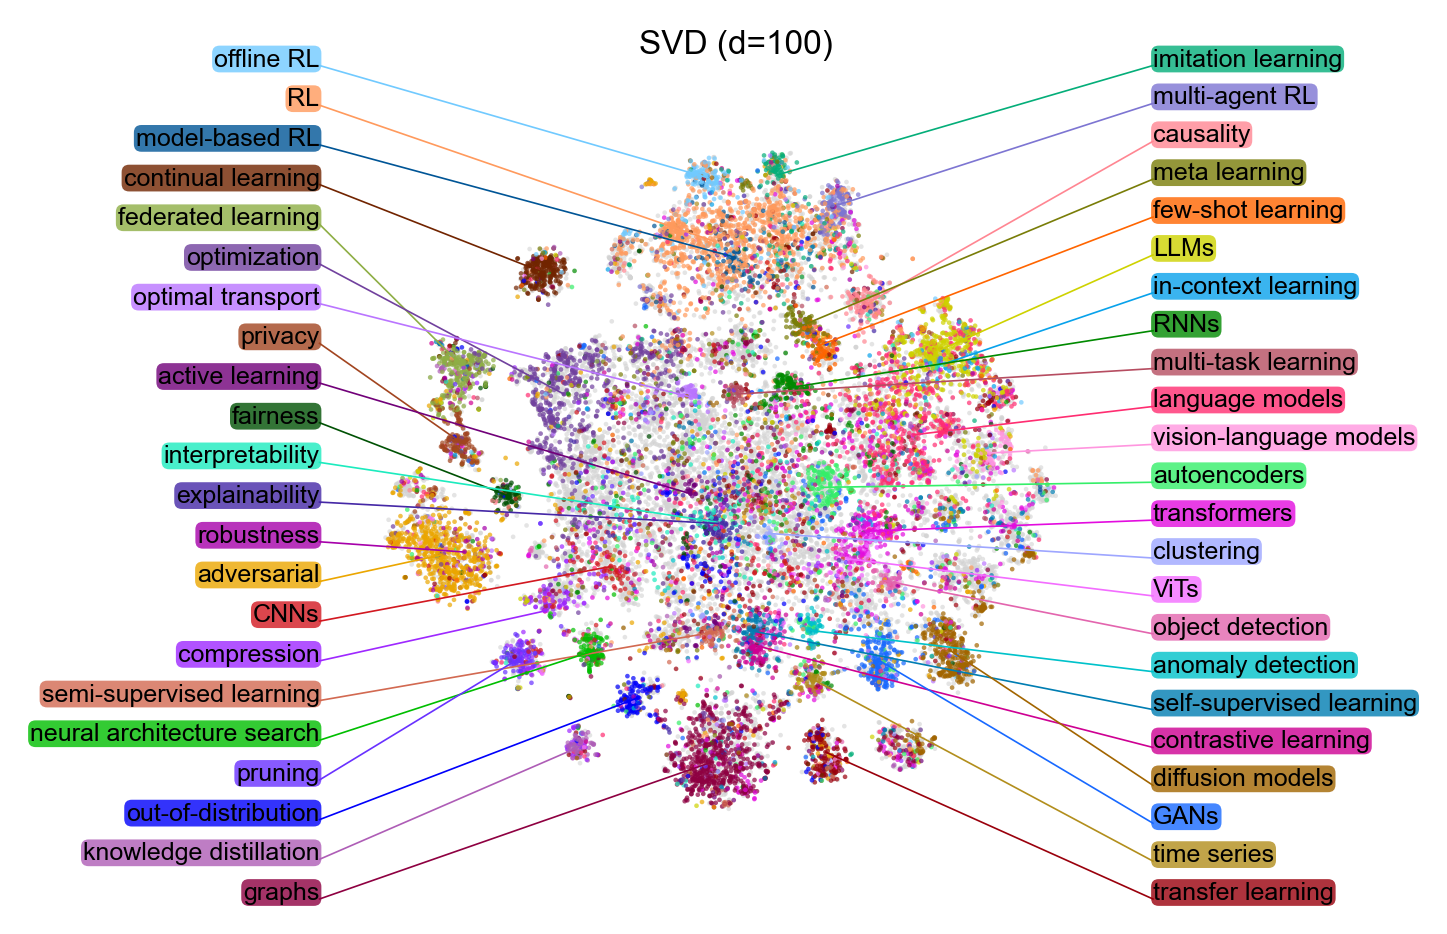

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
xlim = (-100, 100)
ylim = (-100, 100)
tsne_svd = np.load(variables_path / "updated_dataset" / "tsne_svd.npy")
plot_tsne_colors(tsne_svd, colors_iclr, ax=ax, x_lim=xlim, y_lim=ylim)
plot_label_tags(
    tsne_svd,
    colors_iclr,
    dict_label_to_color,
    x_lim=xlim,
    y_lim=ylim,
    ax=ax,
    subset=False,
    fontsize=6,
    capitalize=False,
)
ax.set_title("SVD (d=100)")
fig.savefig(figures_path / "tsne_iclr_svd_with_tags_v3.png")

### RP

In [ ]:
#random_projection = np.load(variables_path / "random_projection.npy")

In [ ]:
%%time
%%memit
A = affinity.Uniform(
    random_projection,
    verbose=True,
    method="exact",
    random_state=42,
    k_neighbors=10,
)
tsne_random_projection = TSNE(
    verbose=True, initialization="spectral", random_state=42
).fit(affinities=A)

np.save(
    variables_path / "updated_dataset" / "tsne_random_projection",
    tsne_random_projection,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


===> Finding 10 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 1.57 seconds
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='spectral', random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating spectral initialization...


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


   --> Time elapsed: 0.38 seconds
===> Running optimization with exaggeration=12.00, lr=2028.92 for 250 iterations...
Iteration   50, KL divergence 7.4025, 50 iterations in 0.9845 sec
Iteration  100, KL divergence 7.4177, 50 iterations in 1.0224 sec
Iteration  150, KL divergence 7.4066, 50 iterations in 1.0183 sec
Iteration  200, KL divergence 7.4285, 50 iterations in 0.9567 sec


Iteration  250, KL divergence 7.4271, 50 iterations in 1.0120 sec
   --> Time elapsed: 4.99 seconds
===> Running optimization with exaggeration=1.00, lr=24347.00 for 500 iterations...
Iteration   50, KL divergence 5.8394, 50 iterations in 0.9814 sec
Iteration  100, KL divergence 5.5958, 50 iterations in 1.3037 sec
Iteration  150, KL divergence 5.4887, 50 iterations in 2.0183 sec
Iteration  200, KL divergence 5.4279, 50 iterations in 2.9373 sec
Iteration  250, KL divergence 5.3895, 50 iterations in 3.9087 sec
Iteration  300, KL divergence 5.3618, 50 iterations in 4.7161 sec
Iteration  350, KL divergence 5.3430, 50 iterations in 5.4010 sec
Iteration  400, KL divergence 5.3273, 50 iterations in 6.3682 sec
Iteration  450, KL divergence 5.3151, 50 iterations in 7.2062 sec
Iteration  500, KL divergence 5.3053, 50 iterations in 8.5313 sec
   --> Time elapsed: 43.37 seconds
peak memory: 4319.27 MiB, increment: 36.30 MiB
CPU times: user 1min 36s, sys: 21.8 s, total: 1min 58s
Wall time: 51.1 s


## Plot
Note: if kNN accuracies are not computed yet, comment them out in the plotting code.

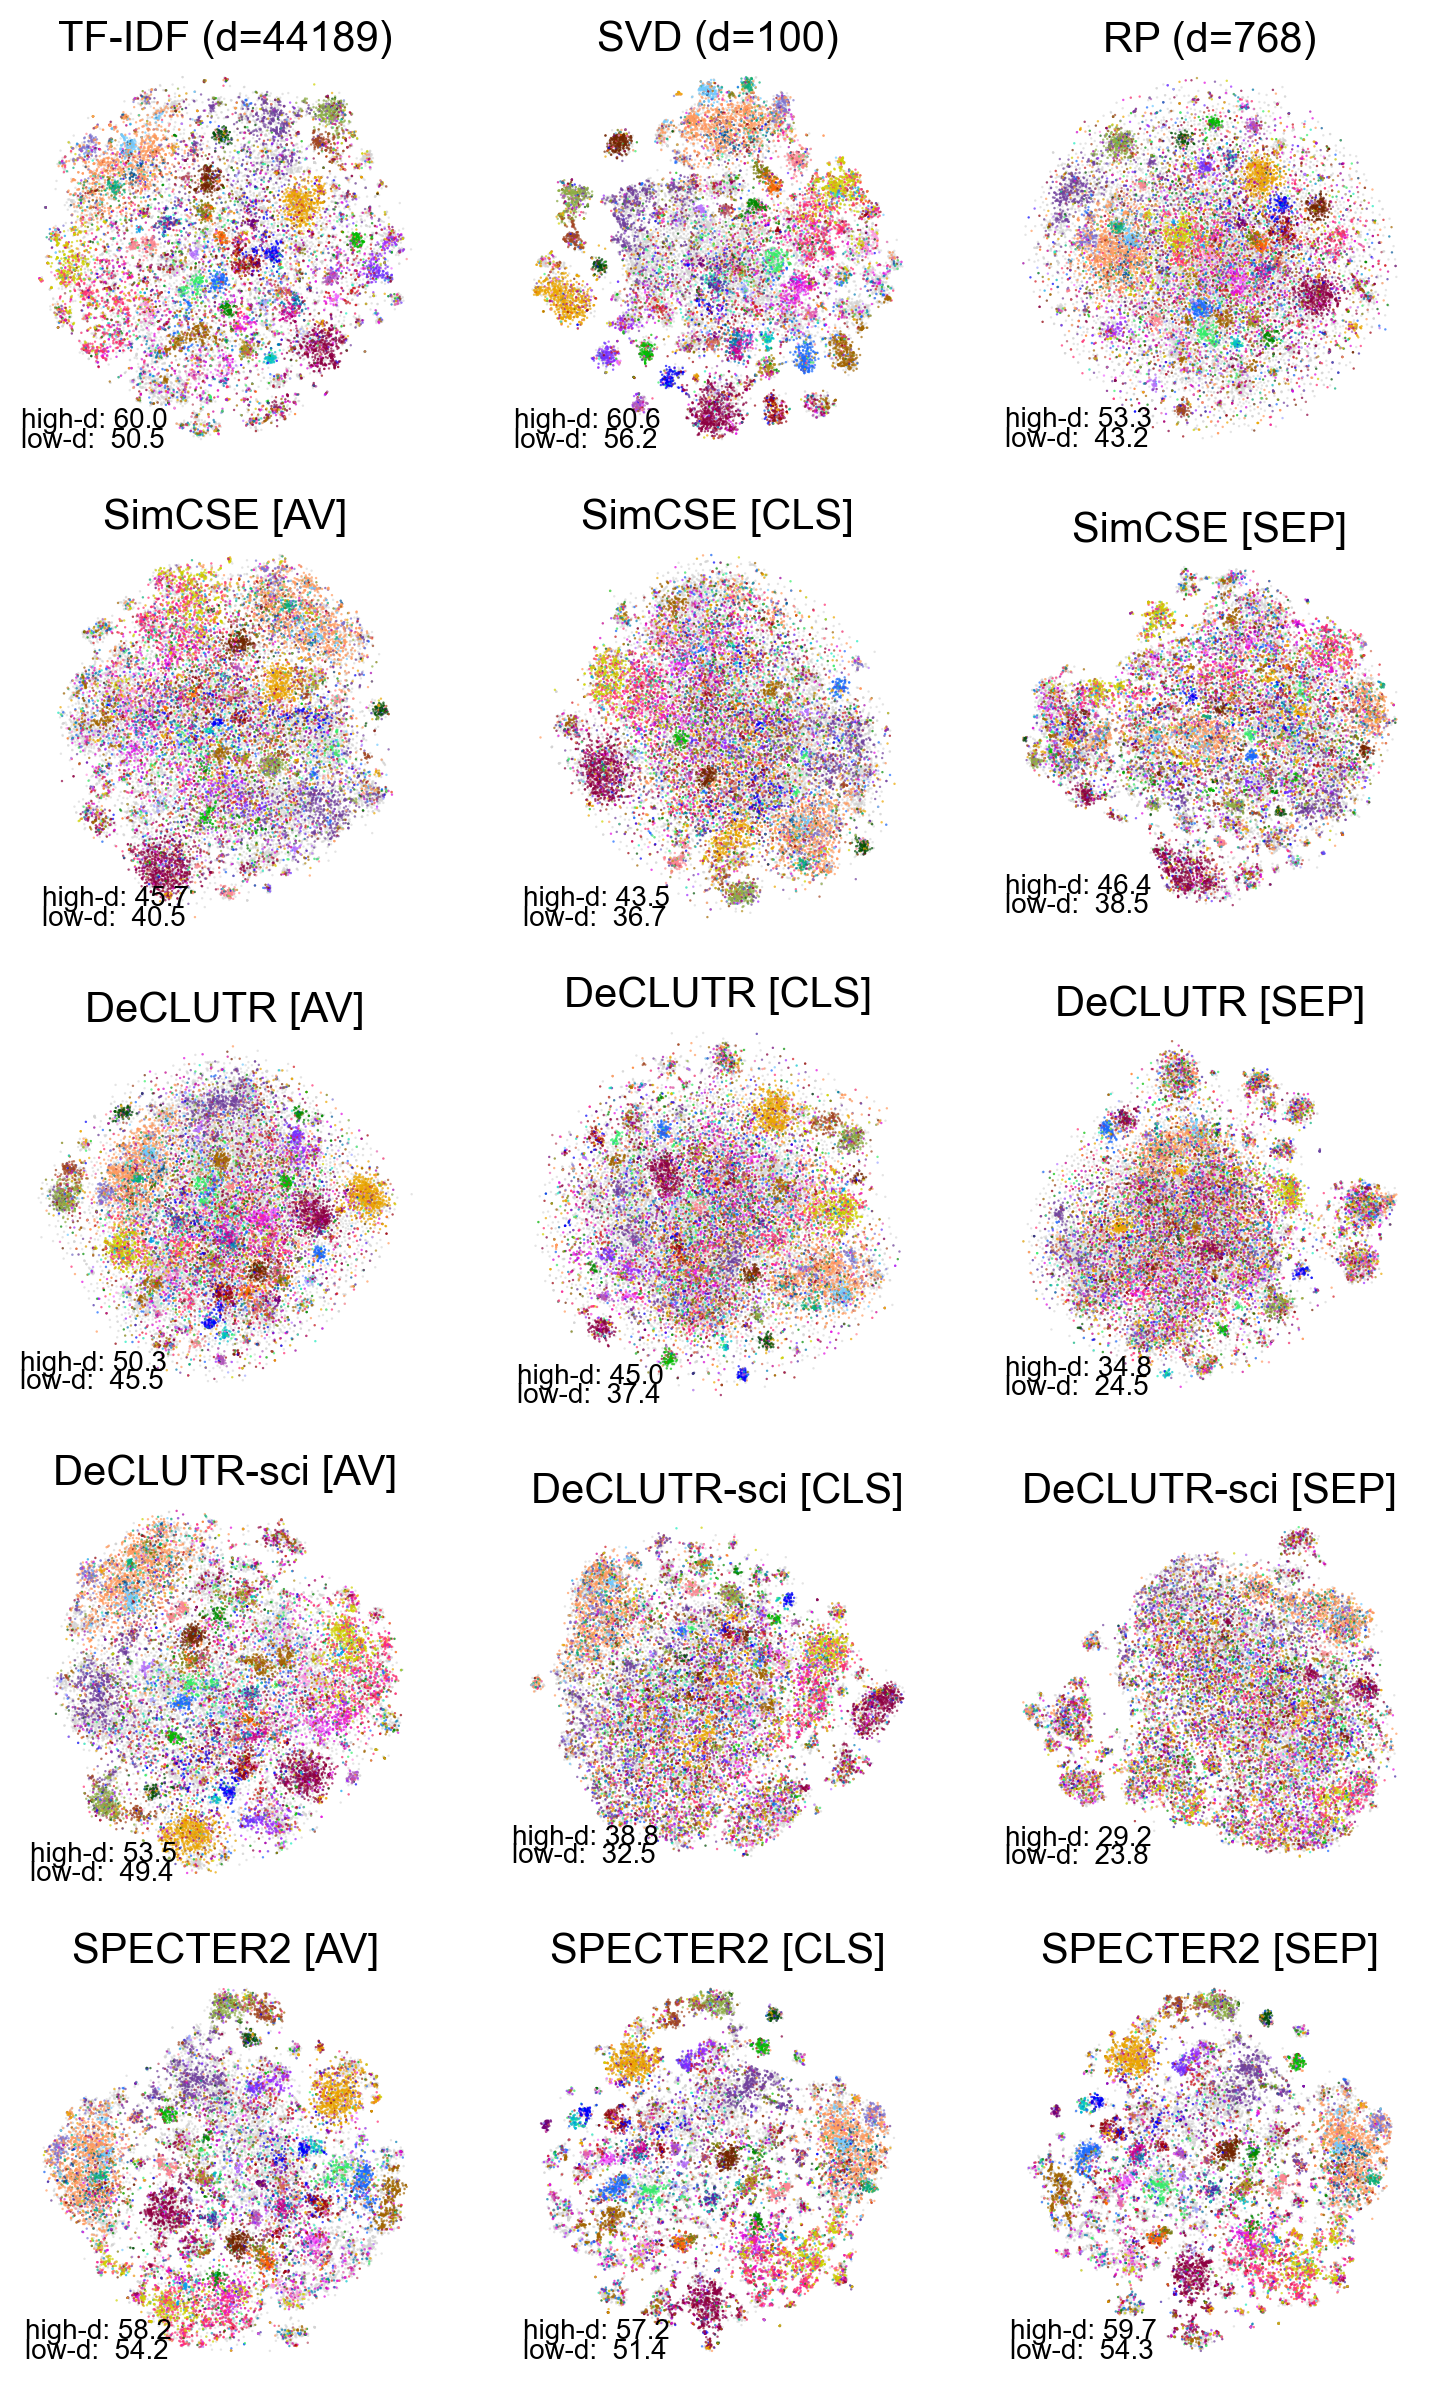

In [ ]:
fig, axs = plt.subplots(
    len(model_names) + 1, 3, figsize=(9, 3 * (len(model_names) + 1)), dpi=200
)
rep = ["av", "cls", "sep"]
for i in range(len(model_names) + 1):
    for j in range(3):
        if (i == 0) & (j == 0):
            # load
            ## tsnes
            tsne_tfidf = np.load(
                variables_path / "updated_dataset" / "tsne_tfidf.npy"
            )
            tsne_svd = np.load(
                variables_path / "updated_dataset" / "tsne_svd.npy"
            )
            tsne_random_projection = np.load(
                variables_path
                / "updated_dataset"
                / "tsne_random_projection.npy"
            )

            ## accuracies
            knn_accuracy_tfidf = np.load(
                variables_path / "updated_dataset" / "knn_accuracy_tfidf.npy"
            )
            knn_accuracy_svd = np.load(
                variables_path / "updated_dataset" / "knn_accuracy_svd.npy"
            )
            knn_accuracy_random_projection = np.load(
                variables_path
                / "updated_dataset"
                / "knn_accuracy_random_projection.npy"
            )

            knn_accuracy_tsne_tfidf = np.load(
                variables_path
                / "updated_dataset"
                / "knn_accuracy_tsne_tfidf.npy"
            )
            knn_accuracy_tsne_svd = np.load(
                variables_path
                / "updated_dataset"
                / "knn_accuracy_tsne_svd.npy"
            )
            knn_accuracy_tsne_random_projection = np.load(
                variables_path
                / "updated_dataset"
                / "knn_accuracy_tsne_random_projection.npy"
            )

            plot_tsne_colors(
                tsne_tfidf, colors_iclr, ax=axs[i, 0], plot_type="subplot_3"
            )
            axs[i, 0].set_title(f"TF-IDF (d=44189)", fontsize=15)

            axs[i, 0].text(
                0,
                0.06,
                f"high-d: {knn_accuracy_tfidf*100:.1f}",
                transform=axs[i, 0].transAxes,
                va="bottom",
                ha="left",
                size=10,
            )
            axs[i, 0].text(
                0,
                0.01,
                f"low-d:  {knn_accuracy_tsne_tfidf*100:.1f}",
                transform=axs[i, 0].transAxes,
                va="bottom",
                ha="left",
                size=10,
            )

            plot_tsne_colors(
                tsne_svd,
                colors_iclr,
                ax=axs[i, 1],
                plot_type="subplot_3",
            )
            axs[i, 1].set_title("SVD (d=100)", fontsize=15)
            axs[i, 1].text(
                0,
                0.06,
                f"high-d: {knn_accuracy_svd*100:.1f}",
                transform=axs[i, 1].transAxes,
                va="bottom",
                ha="left",
                size=10,
            )
            axs[i, 1].text(
                0,
                0.01,
                f"low-d:  {knn_accuracy_tsne_svd*100:.1f}",
                transform=axs[i, 1].transAxes,
                va="bottom",
                ha="left",
                size=10,
            )

            plot_tsne_colors(
                tsne_random_projection,
                colors_iclr,
                ax=axs[i, 2],
                plot_type="subplot_3",
            )
            axs[i, 2].set_title("RP (d=768)", fontsize=15)
            axs[i, 2].text(
                0,
                0.06,
                f"high-d: {knn_accuracy_random_projection*100:.1f}",
                transform=axs[i, 2].transAxes,
                va="bottom",
                ha="left",
                size=10,
            )
            axs[i, 2].text(
                0,
                0.01,
                f"low-d:  {knn_accuracy_tsne_random_projection*100:.1f}",
                transform=axs[i, 2].transAxes,
                va="bottom",
                ha="left",
                size=10,
            )
        elif i != 0:
            # break
            # load
            ## tsnes
            saving_path = Path(
                "embeddings_" + model_names[i - 1].lower()
            ) / Path("updated_dataset")
            tsne_name = "tsne_" + rep[j] + ".npy"
            tsne = np.load(variables_path / saving_path / tsne_name)

            ## accuracies
            saving_name = Path(
                "knn_accuracy_" + model_names[i - 1].lower() + ".npy"
            )
            knn_acc_highd = np.load(
                variables_path / "updated_dataset" / saving_name
            )

            saving_name = Path(
                "knn_accuracy_tsne_" + model_names[i - 1].lower() + ".npy"
            )
            knn_acc_lowd = np.load(
                variables_path / "updated_dataset" / saving_name
            )

            # plot
            plot_tsne_colors(
                tsne, colors_iclr, ax=axs[i, j], plot_type="subplot_3"
            )
            title = model_names[i - 1] + " [" + rep[j].upper() + "]"
            axs[i, j].set_title(title, fontsize=15)
            axs[i, j].text(
                0,
                0.06,
                f"high-d: {knn_acc_highd[j]*100:.1f}",
                transform=axs[i, j].transAxes,
                va="bottom",
                ha="left",
                size=10,
            )
            axs[i, j].text(
                0,
                0.01,
                f"low-d:  {knn_acc_lowd[j]*100:.1f}",
                transform=axs[i, j].transAxes,
                va="bottom",
                ha="left",
                size=10,
            )

fig.savefig(figures_path / "tsne_embeddings_iclr_with_knn_accs_v2.png")